In [1]:
import sys
import numpy as np
import xarray as xr
from scipy.io import loadmat
from datetime import datetime
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
sys.path.append('/Users/jakesteinberg/ECCOv4-py/ECCOv4-py')
import ecco_v4_py as ecco
%matplotlib inline

In [51]:
# -- GOM tide gauges -- 
tg_data = loadmat('/Users/jakesteinberg/Documents/NASA_OSTST/tide_gauge/GOM_gauges.mat')
t_rec = []; 
for i in range(len(tg_data['t_grid'][0,:])):
    t_i = datetime.fromordinal(tg_data['t_grid'][0,i] - 366)
    t_rec.append(t_i)
data_da = xr.DataArray(data=tg_data['height_grid']/1000, dims=["location","time"],
                        coords=dict(
                            location=(["location"], tg_data['ID'][0,:]),
                            time=(["time"], t_rec),
                            lon=(['location'], tg_data['lon'][0,:]),
                            lat=(['location'], tg_data['lat'][0,:]),
                        ),        
                       )

In [3]:
# subset for desired years 
t_s = '2008-01-15'
t_e = '2017-12-15'
tg_sub = data_da.sel(time=slice(t_s, t_e))
tg_sub_a = tg_sub - data_da.sel(time=slice(t_s, t_e)).mean(dim='time')

In [4]:
# fit trend 
p1_test = tg_sub.polyfit(dim='time', deg=1)
p1_test = (p1_test.isel(degree=0).polyfit_coefficients)*1e9*60*60*24*365

In [5]:
# -- ECCO GRIDS -- 
# base_dir = '/home/username/'
base_dir = '/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/'
## define a high-level directory for ECCO fields
ECCO_dir = base_dir + '/v5'
## Load the model grid
grid_dir= ECCO_dir + '/nctiles_grid/'
# ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCOv4r3_grid.nc', k_subset=[0])
ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCO-GRID.nc')

# bathymetry
tile_num=10
lon_range = [-98, -78]; lat_range = [17, 31] 
lons = ecco_grid.XC.sel(tile=tile_num)
lats = ecco_grid.YC.sel(tile=tile_num)
dep = ecco_grid.Depth
dep = dep.where(ecco_grid.hFacC.isel(tile=tile_num,k=0) !=0, np.nan).isel(tile=tile_num)

In [163]:
## ECCO SSH 
data_dir= ECCO_dir + '/nctiles_monthly'   
ecco_daily_vars = ecco.recursive_load_ecco_var_from_years_nc(data_dir, vars_to_load=['ETAN','PHIBOT'],\
                                           years_to_load=range(2008,2018)).load()    
## Merge the ecco_grid with the ecco_vars to make the ecco_ds
ecco_monthly_ds = xr.merge((ecco_grid , ecco_daily_vars))

loading files of  ETAN
loading files of  PHIBOT


In [181]:
# -- OBP --  
# mask at the surface and total ocean area 
ocean_mask = np.ceil(ecco_monthly_ds.hFacC[0])
ocean_mask = ocean_mask.where(ocean_mask==1, np.nan)
total_ocean_area = np.sum(ecco_monthly_ds.rA*ocean_mask)
g = 9.81
rho0 = 1035
obp_cor = 1029*(ecco_monthly_ds.PHIBOT + g*dep) # calculate OBP following ECCO code 
OBP_global_mean_mon = (obp_cor*ecco_monthly_ds.rA).sum(dim=['i','j','tile'])/total_ocean_area # global mean time series 
obp_mgm = obp_cor - OBP_global_mean_mon      # subtract global spatial mean time series 
obp_anom = obp_mgm - obp_mgm.mean(dim='time')  # subtract time mean at each point 
pobp = obp_anom.polyfit(dim='time', deg=1)
obp_a_trend = xr.polyval(obp_anom['time'], pobp.polyfit_coefficients)

In [7]:
# -- Vertical Land Motion -- 
file = open("/Users/jakesteinberg/Documents/NASA_OSTST/tide_gauge/vertical_velocities_table.txt")
# data = file.readlines()
data = np.loadtxt(file,skiprows=13,usecols=(2,3,4,5,6,7))
file.close()
# -- find closest distance from gauges of interest -- 
closest = np.nan*np.ones(len(data_da.lon)); dist_b = np.nan*np.ones(len(data_da.lon)); rate = np.nan*np.ones(len(data_da.lon));
for i in range(len(data_da.lon)):
    sta_lon = data_da.lon[i].data
    sta_lat = data_da.lat[i].data
    dist_x = 1852*60*np.cos(np.deg2rad(sta_lat))*(data[:,0] - sta_lon)
    dist_y = 1852*60*(data[:,1] - sta_lat)
    dist = np.sqrt(dist_x**2 + dist_y**2)
    closest[i] = int(np.where(dist == np.nanmin(dist))[0][0])
    dist_b[i] = dist[int(np.where(dist == np.nanmin(dist))[0][0])]
    rate[i] = data[int(np.where(dist == np.nanmin(dist))[0][0]),4]/1000

In [9]:
# -- compare values 
tg_obp_trend_a = p1_test # - np.nanmean(p1_test)
print('tide gauge trend')
print(tg_obp_trend_a.data)
print('percent of tide gauge trend from VLM')
print(100*(-1*rate/tg_obp_trend_a.data))
tg_obp_trend_a_mvlm = p1_test.data - (-1)*rate
print('VLM corrected tide gauge trend')
print(tg_obp_trend_a_mvlm)

tide gauge trend
[0.01182159 0.01145987 0.01303731 0.01048055 0.01450867 0.01338044
 0.01274324 0.01204648 0.01351487 0.01365693 0.01022123 0.01256775
 0.01545009 0.01833553 0.02088157 0.02202018 0.01589095 0.01373192
 0.01032021]
percent of tide gauge trend from VLM
[ 9.05123583 -3.66496222  2.60790012  3.24410397  2.34342656  6.57676486
  1.49098659  1.5772238   3.10768818  3.07536205  4.10909295 52.03795101
 42.32986034 35.66844975 21.98110334 -1.77110283 22.46561629 25.9978232
 34.59230595]
VLM corrected tide gauge trend
[0.01075159 0.01187987 0.01269731 0.01014055 0.01416867 0.01250044
 0.01255324 0.01185648 0.01309487 0.01323693 0.00980123 0.00602775
 0.00891009 0.01179553 0.01629157 0.02241018 0.01232095 0.01016192
 0.00675021]


/Users/jakesteinberg/anaconda3/envs/ECCOv4_py/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:2011: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)
/Users/jakesteinberg/anaconda3/envs/ECCOv4_py/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jakesteinberg/anaconda3/envs/ECCOv4_py/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylab

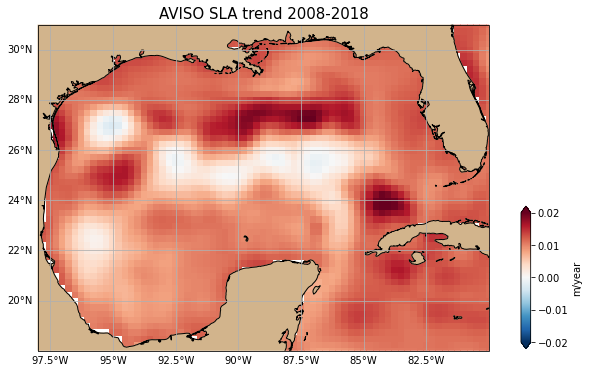

In [10]:
# 2008-2018 GOM find closest SLA trend (AVISO)
av_path = '/Users/jakesteinberg/Documents/NASA_OSTST/AVISO/cmems_obs_sl_glo_phy-ssh_my_allsat_l4_pt25deg_P1D_1646240076063_2008_2018.nc'
av = xr.open_dataset(av_path)
av_time_o = np.where((av.time > ecco_monthly_ds.time[0]) & (av.time < ecco_monthly_ds.time[-1]))[0]
avsla = av.sla[av_time_o,:,:]
avsla = avsla-avsla.mean(dim='time')
pavsla = avsla.polyfit(dim='time', deg=1)
# avsla_trend = xr.polyval(avsla['time'], pavsla.polyfit_coefficients)
# avsla_detrend = avsla - avsla_trend
aviso_sla_trend = pavsla.polyfit_coefficients.isel(degree=0)*1e9*60*60*24*365

clim = [-0.02, 0.02];
colMap = plt.get_cmap('RdBu_r');
f, ax = plt.subplots(1,1,figsize=(9,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
Kc = ax.pcolor(av.longitude,av.latitude,aviso_sla_trend, \
            vmin=clim[0],vmax=clim[-1], cmap=colMap,transform=ccrs.PlateCarree());
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False;
ax.set_xlim([-98,-80]); ax.set_ylim([18,31]);
ax.set_title('AVISO SLA trend 2008-2018',fontsize=15)
cbpos = [0.91, 0.13, 0.015, 0.33]; cax = f.add_axes(cbpos); 
cb = f.colorbar(Kc, cax=cax, orientation='vertical', extend='both', label='m/year')
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_04_20/GOM_aviso_trend.jpg', dpi=250)

In [93]:
# -- MERGE for zoomed out view 
av_path = '/Users/jakesteinberg/Documents/NASA_OSTST/AVISO/cmems_natl_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1993_1998.nc'
av1 = xr.open_dataset(av_path)
av_path = '/Users/jakesteinberg/Documents/NASA_OSTST/AVISO/cmems_natl_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1999_2004.nc'
av2 = xr.open_dataset(av_path)
av_path = '/Users/jakesteinberg/Documents/NASA_OSTST/AVISO/cmems_natl_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_2005_2010.nc'
av3 = xr.open_dataset(av_path)
av_path = '/Users/jakesteinberg/Documents/NASA_OSTST/AVISO/cmems_natl_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_2011_2016.nc'
av4 = xr.open_dataset(av_path)
av_path = '/Users/jakesteinberg/Documents/NASA_OSTST/AVISO/cmems_natl_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_2017_2021.nc'
av5 = xr.open_dataset(av_path)
av_tot = xr.concat([av1,av2,av3,av4,av5], dim='time')

In [150]:
# AVISO SLA 
# av_path = '/Users/jakesteinberg/Documents/NASA_OSTST/AVISO/cmems_obs_ssh_my_allsat_l4_duacs_ptdeg_P1D_1993_2020.nc'
# av = xr.open_dataset(av_path)
# av_time_o = range(len(av.time))
# avsla_raw = av.sla[av_time_o,:,:]

# msl_path = '/Users/jakesteinberg/Documents/NASA_OSTST/AVISO/MSL_Serie_MERGED_Global_AVISO_GIA_NoAdjust_Filter2m.nc'
# av_msl = xr.open_dataset(msl_path)
# msl0 = av_msl.msl.sel(time=slice("1993-01-01", "2017-12-31"))
# msl = msl0.interp(time=avsla_raw.time.data)

avsla_raw = av_tot.sla

# -- remove spatial mean from each time 
# avsla_raw = avsla_raw - msl
# -- remove time mean (if generating master time series plot )
avsla_raw_mean = avsla_raw.sel(time=slice("1993-01-01", "2017-12-31")).mean(dim='time')
avsla_raw = avsla_raw - avsla_raw_mean
# -- extract times 
avsla_trend_time_1 = av_tot.time.sel(time=slice("1993-01-01", "2003-12-31"))
avsla_trend_time_2 = av_tot.time.sel(time=slice("2008-01-01", "2017-12-31"))
avsla_trend_time_tot = av_tot.time.sel(time=slice("1993-01-01", "2019-12-31"))
# -- extract sla over desired times 
avsla_raw_1 = avsla_raw.sel(time=slice("1993-01-01", "2003-12-31"))
avsla_raw_2 = avsla_raw.sel(time=slice("2008-01-01", "2017-12-31"))
avsla_raw_2_mean = avsla_raw_2.mean(dim='time')
avsla_raw_2_a = avsla_raw_2 - avsla_raw_2_mean

avsla_raw_tot = avsla_raw.sel(time=slice("1993-01-01", "2019-12-31"))
# -- trend fit over desired times 
pavsla_1 = avsla_raw_1.polyfit(dim='time', deg=1)
pavsla_2 = avsla_raw_2_a.polyfit(dim='time', deg=1) # fitting the anomaly here! 
pavsla_tot = avsla_raw_tot.polyfit(dim='time', deg=1)
aviso_1_sla_trend = pavsla_1.polyfit_coefficients.isel(degree=0)*1e9*60*60*24*365
aviso_2_sla_trend = pavsla_2.polyfit_coefficients.isel(degree=0)*1e9*60*60*24*365
aviso_tot_sla_trend = pavsla_tot.polyfit_coefficients.isel(degree=0)*1e9*60*60*24*365

avsla_trend_1 = xr.polyval(avsla_raw_1['time'], pavsla_1.polyfit_coefficients)
avsla_trend_2 = xr.polyval(avsla_raw_2['time'], pavsla_2.polyfit_coefficients)

/var/folders/g_/xh2hxbd10wl4stb5spmwldj00000gn/T/ipykernel_65019/1528349562.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


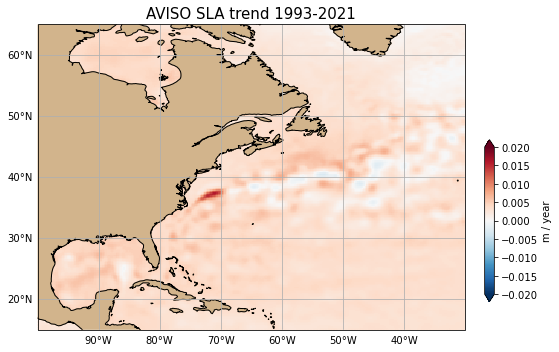

In [15]:
clim = [-0.02, 0.02];
colMap = plt.get_cmap('RdBu_r');
f, ax1 = plt.subplots(1,1,figsize=(9,5), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
Kc = ax1.pcolor(av_tot.longitude,av_tot.latitude,aviso_tot_sla_trend, \
            vmin=clim[0],vmax=clim[-1], cmap=colMap,transform=ccrs.PlateCarree());
ax1.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax1.coastlines()
gl = ax1.gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False;
# ax1.set_xlim([-102,-70]); ax1.set_ylim([17,35]);
ax1.set_xlim([-100,-30]); ax1.set_ylim([15,65]);
ax1.set_title('AVISO SLA trend 1993-2021',fontsize=15)
cbpos = [0.86, 0.15, 0.015, 0.45]; cax = f.add_axes(cbpos); 
cb = f.colorbar(Kc, cax=cax, orientation='vertical', extend='both', label='m / year')
plt.tight_layout()
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_04_20/GOM_aviso_trend_natl_full.jpg', dpi=350)

/Users/jakesteinberg/anaconda3/envs/ECCOv4_py/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:2011: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)
/Users/jakesteinberg/anaconda3/envs/ECCOv4_py/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jakesteinberg/anaconda3/envs/ECCOv4_py/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylab

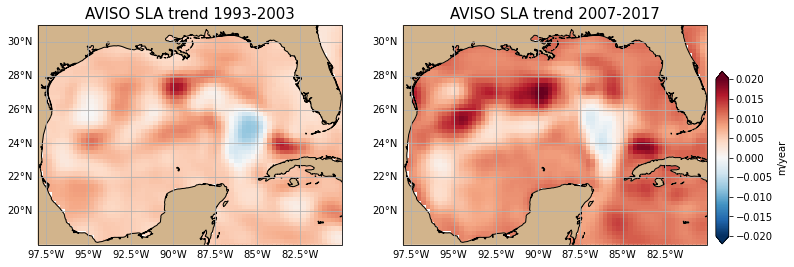

In [29]:
clim = [-0.02, 0.02];
colMap = plt.get_cmap('RdBu_r');
f, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
Kc = ax1.pcolor(av_tot.longitude,av_tot.latitude,aviso_1_sla_trend, \
            vmin=clim[0],vmax=clim[-1], cmap=colMap,transform=ccrs.PlateCarree());
ax1.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax1.coastlines()
gl = ax1.gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False;
ax1.set_xlim([-98,-80]); ax1.set_ylim([18,31]);
ax1.set_title('AVISO SLA trend 1993-2003',fontsize=15)

Kc = ax2.pcolor(av_tot.longitude,av_tot.latitude,aviso_2_sla_trend, \
            vmin=clim[0],vmax=clim[-1], cmap=colMap,transform=ccrs.PlateCarree());
ax2.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax2.coastlines()
gl = ax2.gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False;
ax2.set_xlim([-98,-80]); ax2.set_ylim([18,31]);
ax2.set_title('AVISO SLA trend 2007-2017',fontsize=15)
cbpos = [0.91, 0.25, 0.015, 0.4]; cax = f.add_axes(cbpos); 
cb = f.colorbar(Kc, cax=cax, orientation='vertical', extend='both', label='m/year')
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_04_20/GOM_aviso_trend_gom_2part.jpg', dpi=250)

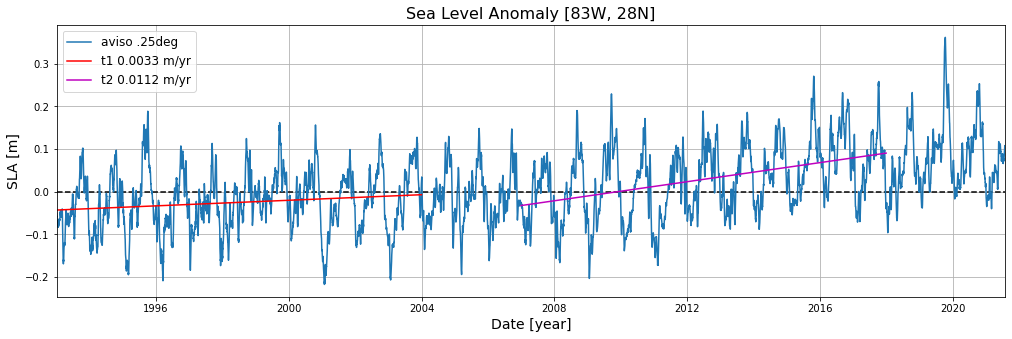

In [15]:
# find aviso index to site selected above
lon_site = -83; lat_site = 28; 
avloni = np.where((av_tot.longitude > lon_site-.15) & (av_tot.longitude < lon_site+.15))[0][0]
avlati = np.where((av_tot.latitude > lat_site-.15) & (av_tot.latitude < lat_site+.15))[0][0]

# -- aviso 
f, (ax) = plt.subplots(1,1,figsize=(17,5))
ax.plot([av_tot.time[0].data, av_tot.time[-1].data], [0,0], color='k', linestyle='--')
ax.plot(av_tot.time, avsla_raw[:, avlati, avloni], label='aviso .25deg',linewidth=1.5); 

# -- aviso trends 
ax.plot(avsla_trend_time_1, avsla_trend_1[:, avlati, avloni], \
        label='t1 ' + str(np.round(pavsla_1.polyfit_coefficients[0, avlati, avloni].data*1e9*60*60*24*365,4)) + ' m/yr', color='r'); 
ax.plot(avsla_trend_time_2, avsla_trend_2[:, avlati, avloni], \
        label='t2 ' + str(np.round(pavsla_2.polyfit_coefficients[0, avlati, avloni].data*1e9*60*60*24*365,4)) + ' m/yr', color='m'); 

ax.grid(); ax.set_xlabel('Date [year]',fontsize=14); ax.set_ylabel('SLA [m]',fontsize=14)
ax.set_title('Sea Level Anomaly ['+str(-1*lon_site) + 'W, ' + str(lat_site) + 'N]', fontsize=16)
ax.set_xlim([av_tot.time[0].data, av_tot.time[-1].data]); ax.legend(fontsize=12)
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_04_20/GOM_aviso_time_series.jpg', dpi=250)

In [133]:
# grid and find AVISO trend nearest to tide gauge 
av_lon, av_lat = np.meshgrid(av_tot.longitude.data, av_tot.latitude.data)
aviso_sla_trend_f = aviso_2_sla_trend.data.flatten()
nb_trend = np.nan*np.ones(len(data_da.lon))
for i in range(len(data_da.lon)):
    sta_lon = data_da.lon[i].data
    sta_lat = data_da.lat[i].data
    dist_x = 1852*60*np.cos(np.deg2rad(sta_lat))*(av_lon.flatten() - sta_lon)
    dist_y = 1852*60*(av_lat.flatten() - sta_lat)
    dist = np.sqrt(dist_x**2 + dist_y**2)
    nearby_i = np.where(dist <= 25000)
    nb_trend[i] = np.nanmean(aviso_sla_trend_f[nearby_i])

In [151]:
# find AVISO time series nearest to tide gauge 
avtgsla = np.nan*np.ones((len(data_da.lon), len(avsla_raw_2.time)))
avtgsla_fit = np.nan*np.ones((len(data_da.lon), len(avsla_raw_2.time)))
for i in range(len(data_da.lon)):
    sta_lon = data_da.lon[i].data
    sta_lat = data_da.lat[i].data
    avloni = np.where((av.longitude.data < (sta_lon+0.35)) & (av.longitude.data > (sta_lon-0.35)))[0]
    avlati = np.where((av.latitude.data < (sta_lat+0.35)) & (av.latitude.data > (sta_lat-0.35)))[0]
    avtgsla[i,:] = np.nanmean(np.nanmean(avsla_raw_2_a[:,avlati,avloni],axis=1),axis=1) 
    avtgsla_fit[i,:] = np.nanmean(np.nanmean(avsla_trend_2[:,avlati,avloni],axis=1),axis=1) 

In [191]:
# find ECCO OBP trend nearest to tide gauge 
ectgobp = np.nan*np.ones(len(data_da.lon))
for i in range(len(data_da.lon)):
    sta_lon = data_da.lon[i].data
    sta_lat = data_da.lat[i].data
    ecli = np.where((lons > sta_lon-.5) & (lons < sta_lon+.5) & (lats > sta_lat-.5) & (lats < sta_lat+.5))
    
    ectgobp[i] = np.nanmean(pobp.isel(tile=10,degree=0).polyfit_coefficients[ecli[0], ecli[1]]*1e9*60*60*24*365/g/rho0)

/var/folders/g_/xh2hxbd10wl4stb5spmwldj00000gn/T/ipykernel_80409/1556654022.py:8: RuntimeWarning: Mean of empty slice
  ectgobp[i] = np.nanmean(pobp.isel(tile=10,degree=0).polyfit_coefficients[ecli[0], ecli[1]]*1e9*60*60*24*365/g/rho0)
/var/folders/g_/xh2hxbd10wl4stb5spmwldj00000gn/T/ipykernel_80409/1556654022.py:8: RuntimeWarning: Mean of empty slice
  ectgobp[i] = np.nanmean(pobp.isel(tile=10,degree=0).polyfit_coefficients[ecli[0], ecli[1]]*1e9*60*60*24*365/g/rho0)


In [152]:
# re-fit trend to tide gauge
p0_test = tg_sub_a.polyfit(dim='time', deg=1)
p1_test = (p0_test.isel(degree=0).polyfit_coefficients)*1e9*60*60*24*365

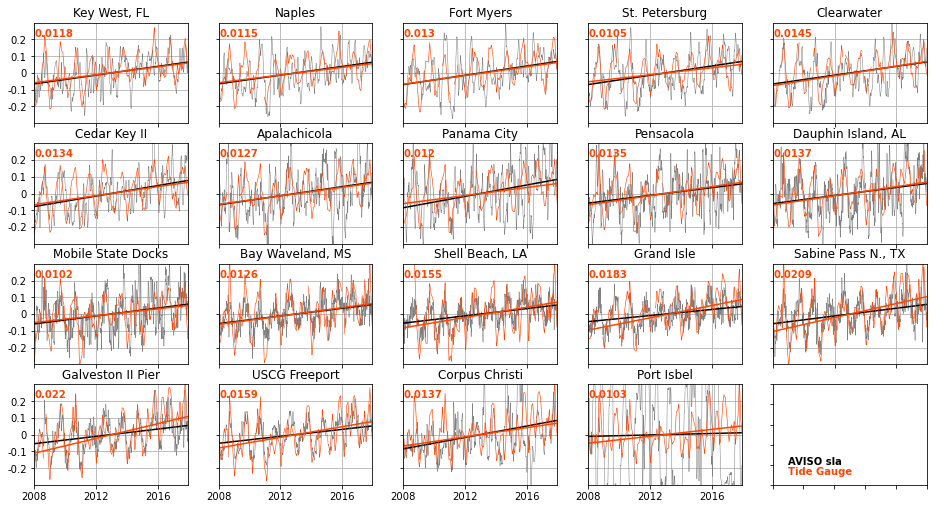

In [206]:
ids = data_da.location.data
id_tags = ['Key West, FL','Naples','Fort Myers','St. Petersburg','Clearwater', 'Cedar Key II', 'Apalachicola', 'Panama City', 'Pensacola', \
          'Dauphin Island, AL', 'Mobile State Docks', 'Bay Waveland, MS' ,'Shell Beach, LA', 'Grand Isle', 'Sabine Pass N., TX', 'Galveston II Pier', \
          'USCG Freeport', 'Corpus Christi', 'Port Isbel']
f, ax = plt.subplots(4,5,figsize=(16,8.5))
axs = ax.flatten()
for i in range(len(axs)-1):
    axs[i].plot(avsla_raw_2.time,avtgsla[i,:],color='#808080',linewidth=0.5)
    axs[i].plot(avsla_raw_2.time,avtgsla_fit[i,:],color='k',linewidth=1.5)
    
    axs[i].plot(data_da.time,data_da.sel(location=ids[i])-np.nanmean(data_da.sel(location=ids[i])),color='#FF4500',linewidth=0.6)
    this_trend = xr.polyval(data_da.time.sel(time=slice(t_s, t_e)), p0_test.polyfit_coefficients[:,i])
    axs[i].plot(data_da.time.sel(time=slice(t_s, t_e)),this_trend,color='#FF4500',linewidth=1.5)
    axs[i].text(avsla_raw_2.time[15],0.22,str(np.round(p0_test.polyfit_coefficients[0,i].data*1e9*60*60*24*365,4)),color='#FF4500',fontweight='bold')

    axs[i].set_title(id_tags[i])
    axs[i].set_ylim([-0.3,0.3])
    axs[i].set_xlim([data_da.time.sel(time=slice(t_s, t_e))[0],data_da.time.sel(time=slice(t_s, t_e))[-1]])
    axs[i].grid()
    axs[i].set_yticklabels('')
    axs[i].set_xticks(['2008','2012','2016'])
    if (i < 15) | (i > 18):
        axs[i].set_xticklabels('')
    if i > 14:
        axs[i].set_xticklabels(['2008','2012','2016'])
    if (i == 0) | (i == 5) | (i == 10) | (i == 15):
        axs[i].set_yticks([-0.2,-0.1,0,0.1,0.2])
        axs[i].set_yticklabels([-0.2,-0.1,0,0.1,0.2])
axs[-1].set_xticklabels('')
axs[-1].set_yticklabels('')
axs[-1].text(0.1,0.1,'Tide Gauge',color='#FF4500',fontweight='bold')
axs[-1].text(0.1,0.2,'AVISO sla',color='k',fontweight='bold')
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_04_20/GOM_tide_gauge_timeseries.jpg', dpi=250)

In [161]:
cmap = mpl.cm.get_cmap('gnuplot',10)
clow = 0.005
chigh = 0.015
norm = mpl.colors.Normalize(vmin=clow, vmax=chigh)

/var/folders/g_/xh2hxbd10wl4stb5spmwldj00000gn/T/ipykernel_80409/3510668811.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ax.scatter(data[np.int(closest[i]),0],data[np.int(closest[i]),1],color='#7CFC00',s=75,transform=ccrs.PlateCarree(),zorder=3,edgecolor='k',marker='x')
/Users/jakesteinberg/anaconda3/envs/ECCOv4_py/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1752: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may chan

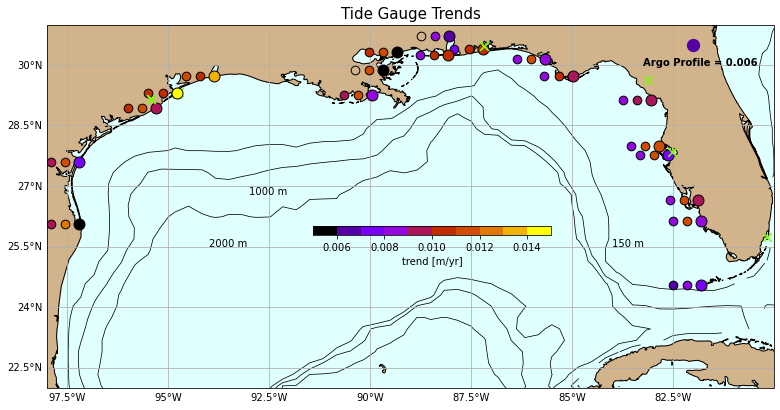

In [207]:
# Locations 
f, ax = plt.subplots(1,1,figsize=(11,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
for i in range(len(tg_data['lat'][0,:])):
    ax.scatter(data[np.int(closest[i]),0],data[np.int(closest[i]),1],color='#7CFC00',s=75,transform=ccrs.PlateCarree(),zorder=3,edgecolor='k',marker='x')
    # -- TG trend minus VLM
    ax.scatter(tg_data['lon'][0,i],tg_data['lat'][0,i],\
               color=[cmap( ((tg_obp_trend_a_mvlm[i]-0.003) - clow)/(chigh - clow) )],s=120,transform=ccrs.PlateCarree(),zorder=3,edgecolor='k')
    # -- TG trend
    # ax.scatter(tg_data['lon'][0,i]+0.35,tg_data['lat'][0,i],\
    #            color=[cmap( (tg_obp_trend_a[i] - clow)/(chigh - clow) )],s=75,transform=ccrs.PlateCarree(),zorder=3,edgecolor='k')
    # -- aviso
    ax.scatter(tg_data['lon'][0,i]-0.35,tg_data['lat'][0,i],\
               color=[cmap( (nb_trend[i] - clow)/(chigh - clow) )],s=75,transform=ccrs.PlateCarree(),zorder=3,edgecolor='k')
    # -- ecco OBP 
    ax.scatter(tg_data['lon'][0,i]-0.7,tg_data['lat'][0,i],\
               color=[cmap( (ectgobp[i] - clow)/(chigh - clow) )],s=75,transform=ccrs.PlateCarree(),zorder=3,edgecolor='k')    

ax.scatter(-82,30.5,color=[cmap( (0.006 - clow)/(chigh - clow) )],s=150,transform=ccrs.PlateCarree(),zorder=3)
ax.text(-83.25,30,'Argo Profile = 0.006', fontweight='bold')
ax.contour(lons,lats,dep,levels=[150],colors='k',transform=ccrs.PlateCarree(),linewidths=0.75)
ax.text(-84,25.5,'150 m', color='k')
ax.contour(lons,lats,dep,levels=[1000],colors='k',transform=ccrs.PlateCarree(),linewidths=0.75)
ax.text(-93,26.8,'1000 m', color='k')
ax.contour(lons,lats,dep,levels=[2000],colors='k',transform=ccrs.PlateCarree(),linewidths=0.75)
ax.text(-94,25.5,'2000 m', color='k')
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False;
ax.set_xlim([-98,-80]); ax.set_ylim([22,31]);
ax.set_title('Tide Gauge Trends',fontsize=15)
cbpos = [0.4, 0.43, 0.3, 0.02]; cax = f.add_axes(cbpos); 
ax.set_facecolor('#E0FFFF');
# cb = f.colorbar(arg_d_p, cax=cax, orientation='vertical', label=r'depth [m]')
f.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cax, orientation='horizontal', label='trend [m/yr]')
plt.tight_layout()
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_04_20/GOM_tg_locs_GRACE_corrected.jpg', dpi=250)

In [120]:
nb_trend

array([0.01034107, 0.01264219, 0.01273066, 0.0122491 , 0.01237314,
       0.01134915, 0.0118723 , 0.01213805, 0.01113358, 0.01123332,
       0.00998862, 0.01231523, 0.01296707, 0.01219524, 0.01272233,
       0.01314011, 0.01330125, 0.01290779, 0.01494085])